In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import io
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from PIL import Image
import seaborn as sns
import pandas as pd

import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Modelul care este o retea neurala convolutionala (CNN), care consta dintr-un strat convolutional, o activare ReLU, un strat de pooling si un strat complet conectat.

Primul strat convolutional cu dimensiunea kernelului 3x3, stride 1 si padding 1 pentru pastrarea dimensiunii spatiale a imaginii.
Functia de activare ReLU e o functie de activare pentru a elimina liniaritatea modelului.

Stratul de MaxPooling ajuta la prevenirea overfitting-ului.

Functia forward defineste fluxul datelor prin retea, se aplatizeaza tensorul si se aplica stratul final cu dimensiunea egala cu numarul de clase.



In [ ]:
class ModelWithResidual(nn.Module):
    def __init__(self):
        super(ModelWithResidual, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Setarea parametrilor pentru model

In [ ]:
# Set hyperparameters
num_classes = 8
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
num_epochs = 20
optimizers = ['SGD', 'Adam']


# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


Datasetul pentru acest clasificator de imagini consta in imagini cu microorganisme, acesta fiind impartit in 8 tipuri specifice: Amoeba, Euglena, Hydra, Paramecium, Rod_bacteria, Spherical_bacteria, Spiral_bacteria, Yeast.

Setul de imagini este trecut printr-un set de transformari care sunt utilizate pentru augmentarea imaginilor. Aceste transformari sunt aplicate in timpul incarcarii datelor pentru a creste diversitatea setului de antrenament si a ajuta modelul sa generalizeze mai bine. Primul pas este redimensionarea imaginilor la 128x128 pixeli, rotatie aleatorie cu un unghi maxim de 10 grade, modificari aleatorii ale luminiozitatii, contrastului, saturatiei si nuantei, iar apoi transformarea imaginii in tensor care normalizeaza pixelii in intervalul [0,1].

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Flip orizontal aleatoriu
    transforms.RandomRotation(10),      # Rotație aleatorie
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Ajustare contrast aleatorie
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Încărcarea setului de date
dataset_path = "/content/drive/MyDrive/DatasetSI"
dataset = ImageFolder(dataset_path, transform=transform)

# Set the sizes for train, validation, and test sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

Creearea de Loadere pentru incarcarea iamaginilor in mini-batch-uri.

Definirea functiei de loss care e utilizata pentru sarcini de clasificare multi-clasa.

Inițializarea listelor pentru pierdere și acuratețe: Acestea sunt utilizate pentru a stoca pierderile și acuratețile pe parcursul antrenamentului.
Inițializarea variabilelor pentru etichete adevărate, predicții și imagini: Acestea sunt utilizate pentru a stoca valorile pentru evaluarea pe setul de test.

In procesul de antrenare a modelului am iterat peste cateva combinatii de parametrii: learning_rate, batch_size, optimizatoare si functii de loss.

Pentru fiecare batch, se reseteaza gradientele la zero, se face forward-pass prin model si se calculeaza loss-ul, se face backward pass si apoi optimizare.

Forward-> propagarea datelor prin retea, strat cu strat pentru obtinerea predictiilor finale.

Backward -> faza in care gradientii se calculeaza si care vor utilizati in actualizarea parametrilor modelului.

Se calculeaza eroarea prin diferenta dintre predictia modelului si valoarea reala.

Se propaga inapoi in retea eroarea prin toate straturile acesteia.

Se actualizeaza parametrii folosind gradientii calculati si optimizatorul declarat.

Se acumuleaza pierderile si se calculeaza acuratetea pentru batch-ul curent, apoi facandu-se media acestora.




Learning Rate: 0.001, Optimizer: SGD, Batch Size: 128
Epoch [1/20], Train Loss: 2.0771, Train Accuracy: 0.2034, Validation Loss: 2.0863, Validation Accuracy: 0.1899
Epoch [2/20], Train Loss: 2.0554, Train Accuracy: 0.2112, Validation Loss: 2.3062, Validation Accuracy: 0.1646
Epoch [3/20], Train Loss: 2.3318, Train Accuracy: 0.1988, Validation Loss: 2.1604, Validation Accuracy: 0.1266
Epoch [4/20], Train Loss: 2.1319, Train Accuracy: 0.2067, Validation Loss: 1.9952, Validation Accuracy: 0.2152
Epoch [5/20], Train Loss: 1.9625, Train Accuracy: 0.2534, Validation Loss: 2.0300, Validation Accuracy: 0.2152
Epoch [6/20], Train Loss: 1.9320, Train Accuracy: 0.2833, Validation Loss: 2.0333, Validation Accuracy: 0.2152
Epoch [7/20], Train Loss: 1.9910, Train Accuracy: 0.2457, Validation Loss: 2.1787, Validation Accuracy: 0.2152
Epoch [8/20], Train Loss: 1.9348, Train Accuracy: 0.2785, Validation Loss: 1.9639, Validation Accuracy: 0.2532
Epoch [9/20], Train Loss: 1.9888, Train Accuracy: 0.2661, 

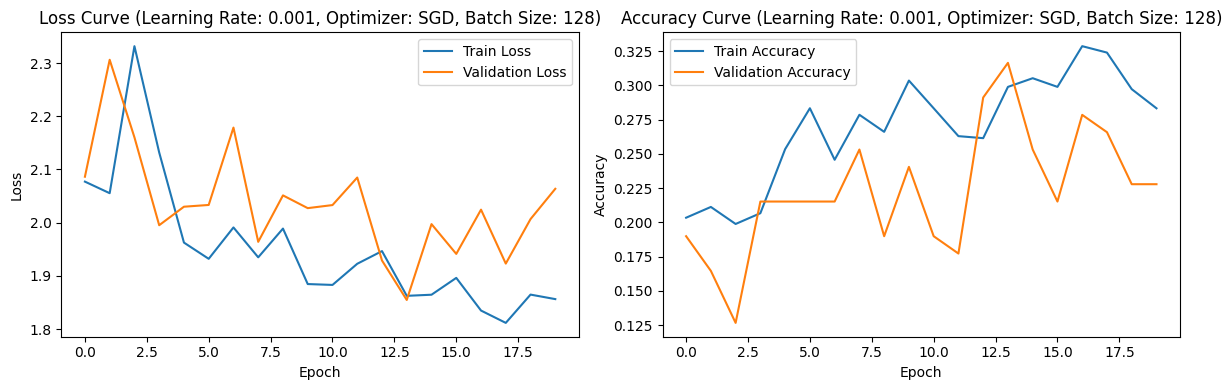

Validation Accuracy: 0.2278

Learning Rate: 0.001, Optimizer: Adam, Batch Size: 128
Epoch [1/20], Train Loss: 14.4450, Train Accuracy: 0.1345, Validation Loss: 14.8626, Validation Accuracy: 0.1013
Epoch [2/20], Train Loss: 9.3105, Train Accuracy: 0.1691, Validation Loss: 6.8107, Validation Accuracy: 0.2405
Epoch [3/20], Train Loss: 5.8830, Train Accuracy: 0.2644, Validation Loss: 5.3377, Validation Accuracy: 0.2532
Epoch [4/20], Train Loss: 4.7386, Train Accuracy: 0.2098, Validation Loss: 4.0045, Validation Accuracy: 0.2405
Epoch [5/20], Train Loss: 3.4687, Train Accuracy: 0.2567, Validation Loss: 4.1280, Validation Accuracy: 0.1772
Epoch [6/20], Train Loss: 2.9125, Train Accuracy: 0.3146, Validation Loss: 2.9760, Validation Accuracy: 0.1772
Epoch [7/20], Train Loss: 2.4888, Train Accuracy: 0.2771, Validation Loss: 2.8963, Validation Accuracy: 0.3291
Epoch [8/20], Train Loss: 2.2673, Train Accuracy: 0.3207, Validation Loss: 2.4392, Validation Accuracy: 0.2785
Epoch [9/20], Train Loss: 

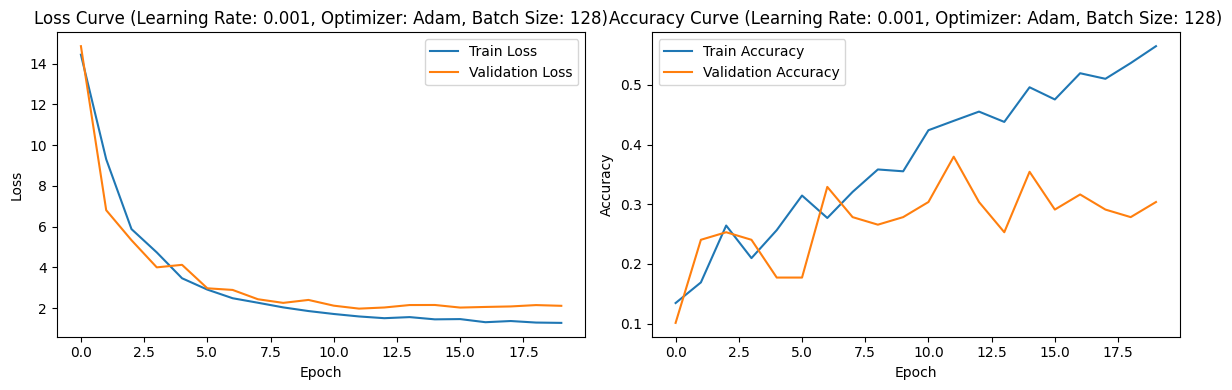

Validation Accuracy: 0.3544

Learning Rate: 0.01, Optimizer: SGD, Batch Size: 128
Epoch [1/20], Train Loss: 11.8207, Train Accuracy: 0.1501, Validation Loss: 10.5376, Validation Accuracy: 0.1139
Epoch [2/20], Train Loss: 4.6701, Train Accuracy: 0.1253, Validation Loss: 2.0744, Validation Accuracy: 0.2278
Epoch [3/20], Train Loss: 2.0675, Train Accuracy: 0.2191, Validation Loss: 2.2253, Validation Accuracy: 0.2152
Epoch [4/20], Train Loss: 1.9858, Train Accuracy: 0.2629, Validation Loss: 2.1740, Validation Accuracy: 0.2532
Epoch [5/20], Train Loss: 1.9234, Train Accuracy: 0.2582, Validation Loss: 1.9395, Validation Accuracy: 0.2658
Epoch [6/20], Train Loss: 1.8783, Train Accuracy: 0.3083, Validation Loss: 2.0700, Validation Accuracy: 0.2278
Epoch [7/20], Train Loss: 1.8644, Train Accuracy: 0.2989, Validation Loss: 1.9807, Validation Accuracy: 0.2532
Epoch [8/20], Train Loss: 1.8336, Train Accuracy: 0.3116, Validation Loss: 2.0678, Validation Accuracy: 0.1772
Epoch [9/20], Train Loss: 1.

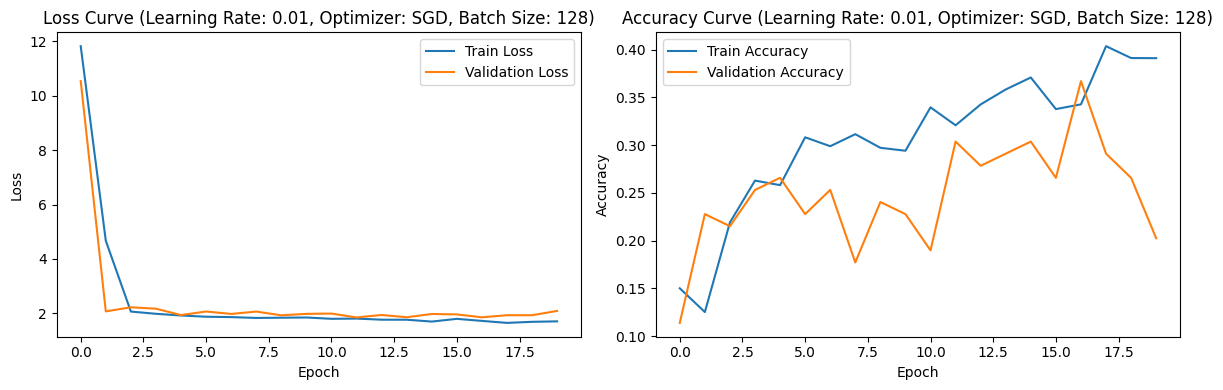

Validation Accuracy: 0.2278

Learning Rate: 0.01, Optimizer: Adam, Batch Size: 128
Epoch [1/20], Train Loss: 98.8525, Train Accuracy: 0.1471, Validation Loss: 89.1349, Validation Accuracy: 0.1266
Epoch [2/20], Train Loss: 80.1940, Train Accuracy: 0.1472, Validation Loss: 59.3625, Validation Accuracy: 0.2911
Epoch [3/20], Train Loss: 35.1176, Train Accuracy: 0.2722, Validation Loss: 25.5194, Validation Accuracy: 0.2911
Epoch [4/20], Train Loss: 19.0213, Train Accuracy: 0.1987, Validation Loss: 14.6925, Validation Accuracy: 0.2532
Epoch [5/20], Train Loss: 13.5637, Train Accuracy: 0.2269, Validation Loss: 8.9485, Validation Accuracy: 0.2278
Epoch [6/20], Train Loss: 7.7542, Train Accuracy: 0.2238, Validation Loss: 9.3400, Validation Accuracy: 0.2025
Epoch [7/20], Train Loss: 6.6446, Train Accuracy: 0.2286, Validation Loss: 6.7844, Validation Accuracy: 0.1899
Epoch [8/20], Train Loss: 4.8194, Train Accuracy: 0.2848, Validation Loss: 4.7944, Validation Accuracy: 0.1772
Epoch [9/20], Train 

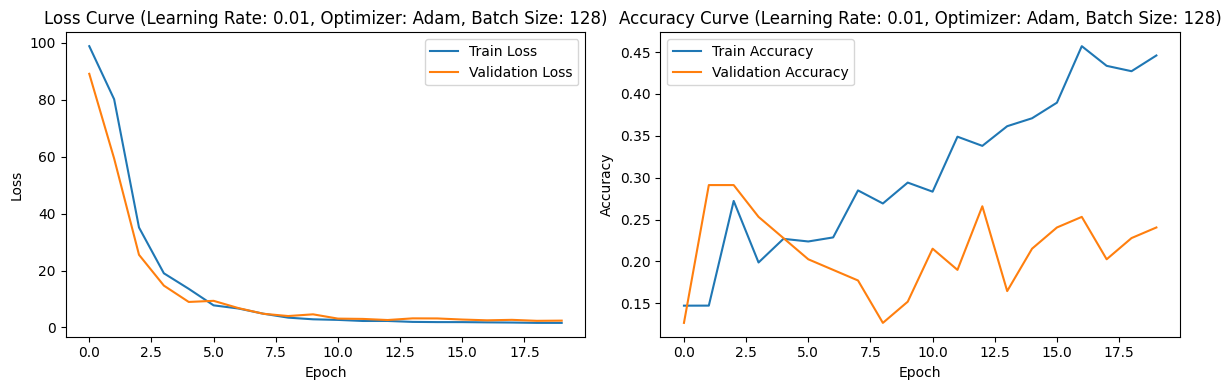

Validation Accuracy: 0.2532



In [ ]:
# Create data loaders
batch_size=128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Define the loss function
criterion = nn.CrossEntropyLoss()
# Iterate over different learning rates
for learning_rate in learning_rates:
    # Iterate over different optimizers
    for optimizer_name in optimizers:
        print(f"Learning Rate: {learning_rate}, Optimizer: {optimizer_name}, Batch Size: {batch_size}")

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        true_labels = []
        predictions = []
        images = []

        # Instantiate the models
        model_with_residual = ModelWithResidual().to(device)

        # Define the optimizers
        if optimizer_name == 'SGD':
            optimizer_with_residual = optim.SGD(model_with_residual.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adam':
            optimizer_with_residual = optim.Adam(model_with_residual.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(num_epochs):
            # Set models to training mode
            model_with_residual.train()

            running_loss = 0.0
            running_accuracy = 0.0

            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer_with_residual.zero_grad()

                # Forward pass
                outputs_with_residual = model_with_residual(inputs)
                loss_with_residual = criterion(outputs_with_residual, labels)
                accuracy_with_residual = calculate_accuracy(outputs_with_residual, labels)

                # Backward pass
                loss_with_residual.backward()
                optimizer_with_residual.step()

                # Accumulate the loss and accuracy
                running_loss += loss_with_residual.item()
                running_accuracy += accuracy_with_residual

            # Calculate average loss and accuracy for epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = running_accuracy / len(train_loader)

            # Append loss and accuracy for plotting
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            # Validation
            model_with_residual.eval()
            val_running_loss = 0.0
            val_running_accuracy = 0.0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs_with_residual = model_with_residual(inputs)
                    loss_with_residual = criterion(outputs_with_residual, labels)
                    accuracy_with_residual = calculate_accuracy(outputs_with_residual, labels)

                    val_running_loss += loss_with_residual.item()
                    val_running_accuracy += accuracy_with_residual

            val_loss = val_running_loss / len(val_loader)
            val_accuracy = val_running_accuracy / len(val_loader)

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Print epoch statistics
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Plot the loss and accuracy curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss Curve (Learning Rate: {learning_rate}, Optimizer: {optimizer_name}, Batch Size: {batch_size})")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy Curve (Learning Rate: {learning_rate}, Optimizer: {optimizer_name}, Batch Size: {batch_size})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Set the model to evaluation mode
        model_with_residual.eval()

        with torch.no_grad():
            total_correct_with_residual = 0
            total_samples = 0

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs_with_residual = model_with_residual(inputs)
                _, predicted_with_residual = torch.max(outputs_with_residual, 1)
                total_correct_with_residual += (predicted_with_residual == labels).sum().item()

                if abs(learning_rate - 0.001) < 1e-6 and batch_size == 32:
                    true_labels.extend(labels.cpu().numpy())
                    predictions.extend(predicted_with_residual.cpu().numpy())
                    images.extend(inputs.cpu().numpy())

                total_samples += labels.size(0)

            val_accuracy_with_residual = total_correct_with_residual / total_samples
            print("Validation Accuracy: {:.4f}".format(val_accuracy_with_residual))
            print()

Calcularea Matricii de Confuzie


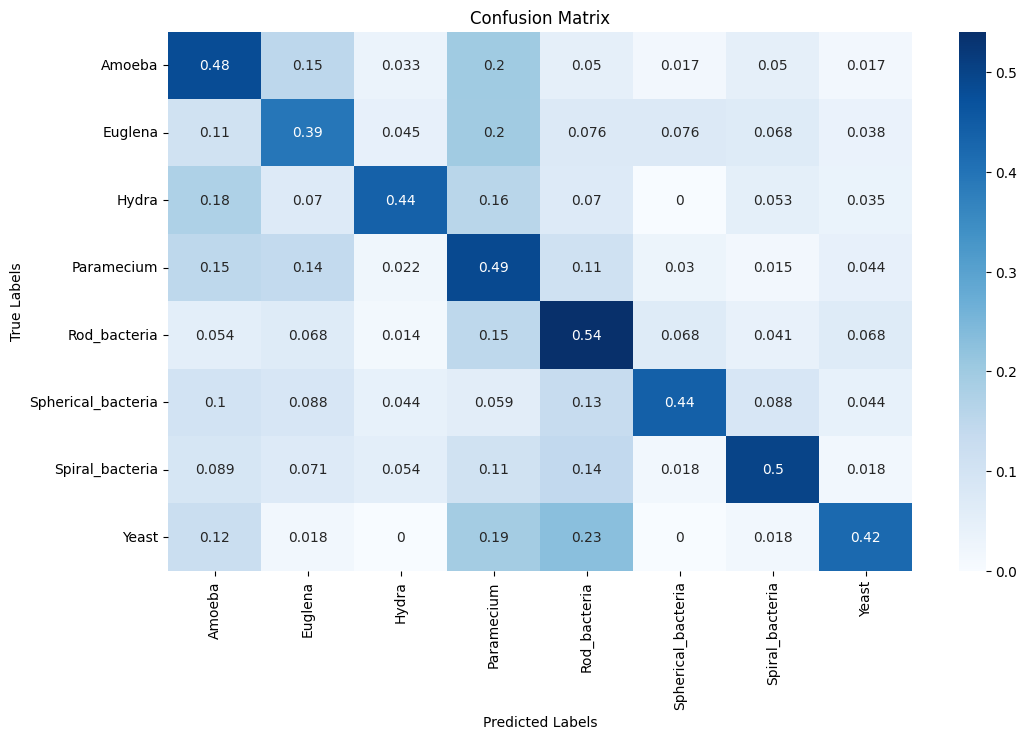

In [ ]:
# constante pentru clase
classes = ["Amoeba", "Euglena", "Hydra", "Paramecium", "Rod_bacteria", "Spherical_bacteria", "Spiral_bacteria", "Yeast"]


def createConfusionMatrix(loader, model):
    model.eval()
    y_pred = []  # salvam predicțiile
    y_true = []  # salvam valorile adevărate

    # iterare peste date
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs)
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # salvam predicțiile

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)  # salvam valorile adevărate


    # construirea matricei de confuzie
    cf_matrix = confusion_matrix(y_true, y_pred)

    return cf_matrix

cf_matrix=createConfusionMatrix(train_loader, model_with_residual)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes]).astype(float)
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Calcularea x-mean si std_dev

Calcularea distributiilor claselor

Media: tensor([0.0766, 0.2939, 0.4813])
Abaterea standard: tensor([1.2976, 1.2957, 1.3079])


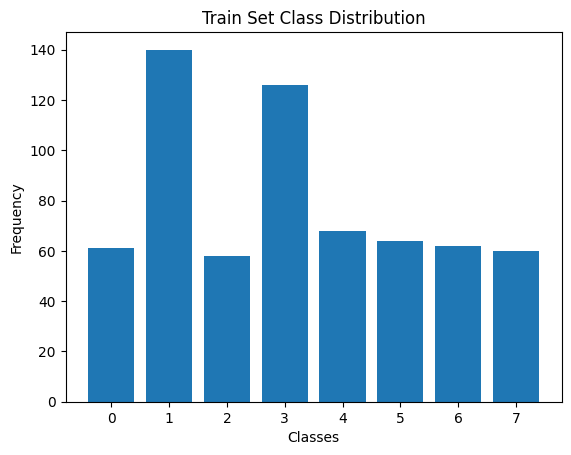

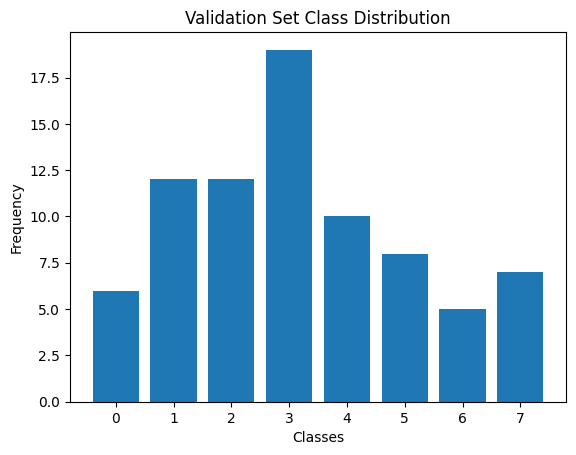

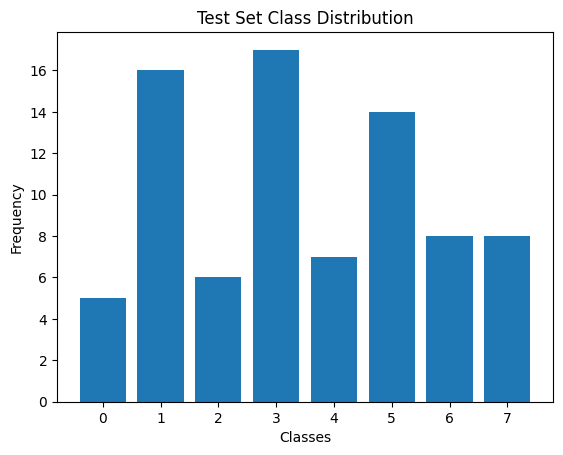

In [ ]:

# functie pentru calcularea mediei si a abaterii standard
def compute_mean_std(dataloader):
  channels_sum,channels_squared_sum,num_batches=0,0,0

  for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

  mean = channels_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2)**0.5

  return mean, std

# Calculăm media și abaterea standard pe setul de antrenament
mean, std = compute_mean_std(train_loader)
print(f'Media: {mean}')
print(f'Abaterea standard: {std}')


def plot_class_distribution(loader, title):
    class_counts = np.bincount([label for _, label in loader.dataset])
    plt.bar(range(len(class_counts)), class_counts)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


plot_class_distribution(train_loader, 'Train Set Class Distribution')
plot_class_distribution(val_loader, 'Validation Set Class Distribution')
plot_class_distribution(test_loader, 'Test Set Class Distribution')



# Afisarea histogramelor

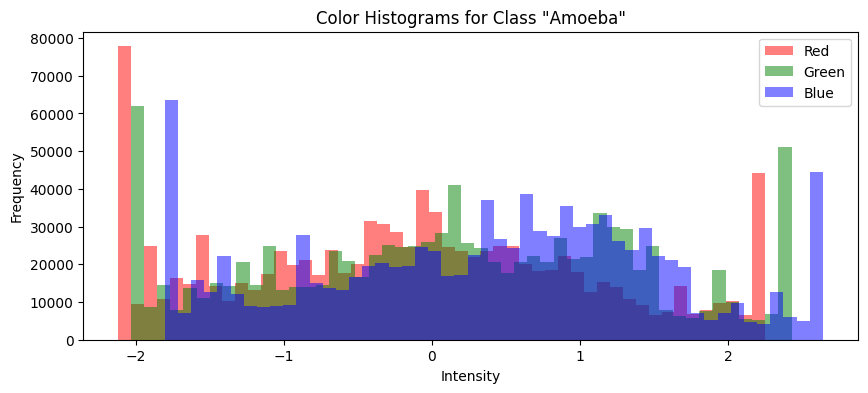

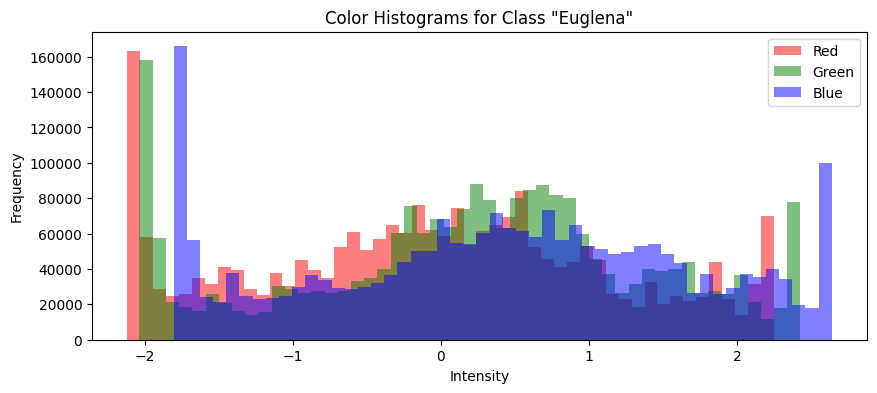

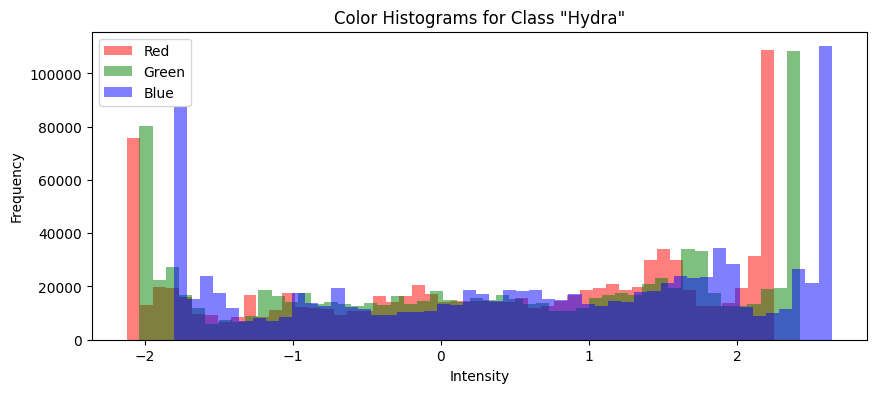

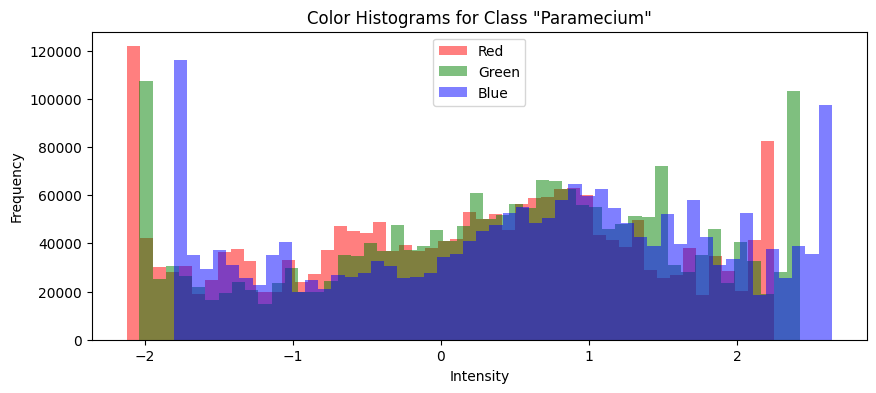

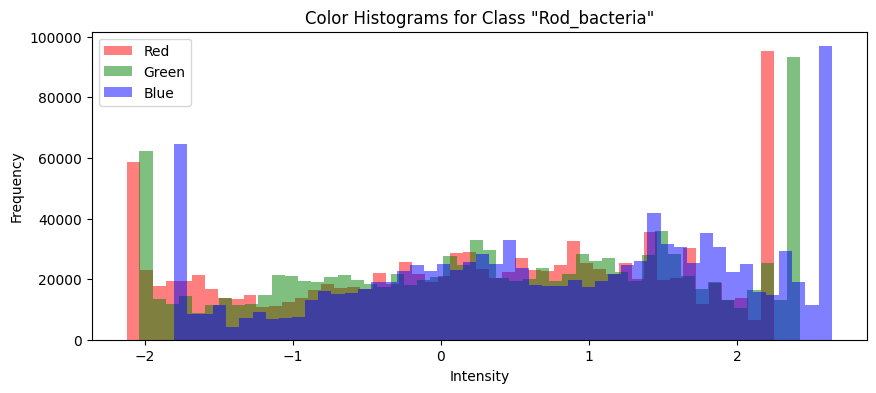

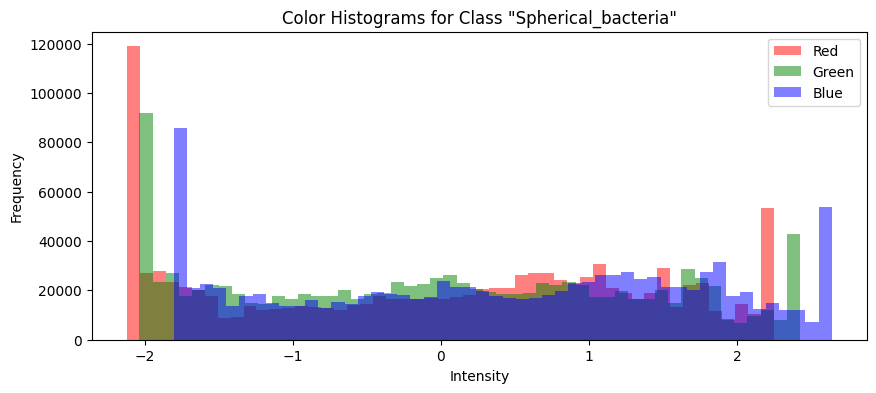

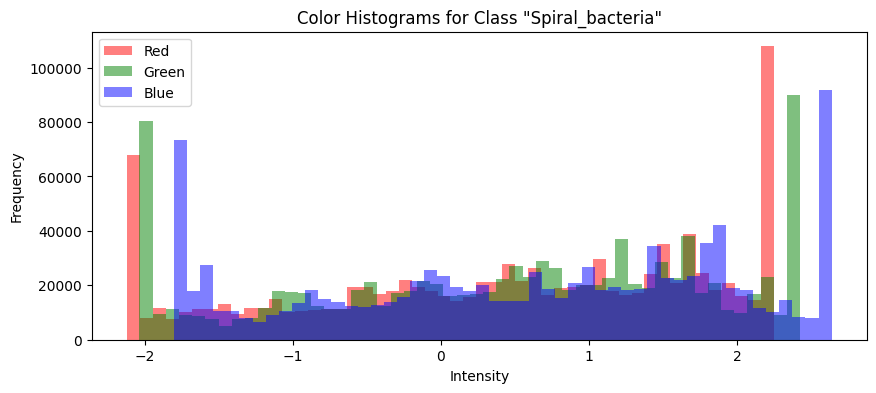

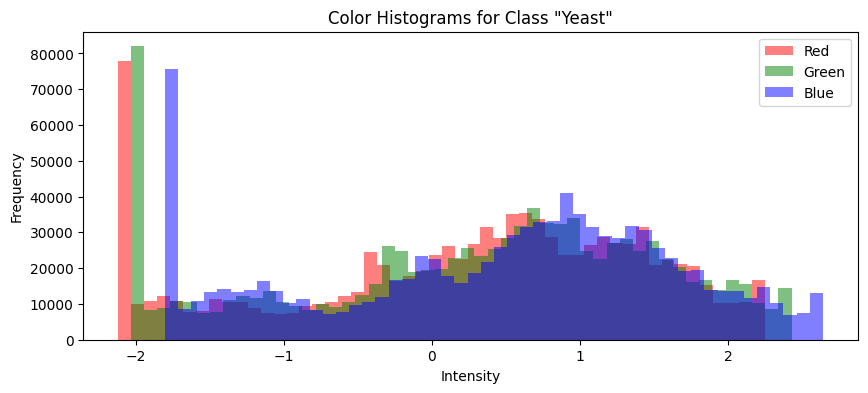

In [ ]:
# Get class names from the dataset
classes = ["Amoeba","Euglena","Hydra","Paramecium","Rod_bacteria","Spherical_bacteria","Spiral_bacteria","Yeast"]

# Function to plot color histograms for a specific class
def plot_color_histograms_for_class(dataset, class_index, class_name):
    red_values = []
    green_values = []
    blue_values = []

    for images, labels in dataset:
        for image, label in zip(images, labels):
            if label == class_index:
                red_channel = image[0, :, :].numpy().flatten()
                green_channel = image[1, :, :].numpy().flatten()
                blue_channel = image[2, :, :].numpy().flatten()

                red_values.extend(red_channel)
                green_values.extend(green_channel)
                blue_values.extend(blue_channel)

    plt.figure(figsize=(10, 4))
    plt.hist(red_values, bins=50, color='red', alpha=0.5, label='Red')
    plt.hist(green_values, bins=50, color='green', alpha=0.5, label='Green')
    plt.hist(blue_values, bins=50, color='blue', alpha=0.5, label='Blue')

    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Color Histograms for Class "{class_name}"')
    plt.legend()
    plt.show()

# Plot color histograms for all classes
for class_index, class_name in enumerate(classes):
    plot_color_histograms_for_class(train_loader, class_index, class_name)



## Acuratetea

In [ ]:
model_with_residual.eval()
test_total = 0
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_with_residual(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.2963


## Recall-ul

In [ ]:
# Calculate recall for each class

recall_per_class = np.diag(cf_matrix) / np.sum(cf_matrix, axis=1)

# Print recall for each class
for idx, class_name in enumerate(classes):
    print(f"Recall for class {class_name}: {recall_per_class[idx]:.4f}")

Recall for class Amoeba: 0.4833
Recall for class Euglena: 0.3939
Recall for class Hydra: 0.4386
Recall for class Paramecium: 0.4889
Recall for class Rod_bacteria: 0.5405
Recall for class Spherical_bacteria: 0.4412
Recall for class Spiral_bacteria: 0.5000
Recall for class Yeast: 0.4211


## Entropia

In [ ]:

model_with_residual.eval()

test_entropy = 0.0
num_batches = 0

eps = 1e-8

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_with_residual(inputs)
        probabilities = F.softmax(outputs, dim=1)
        log_probabilities = torch.log(probabilities + eps)
        entropy = -torch.sum(probabilities * log_probabilities, dim=1).mean()

        test_entropy += entropy.item()
        num_batches += 1

test_entropy /= num_batches

print(f"Test Entropy: {test_entropy:.4f}")

Test Entropy: 1.5435


# Teste

In [ ]:

plt.figure(figsize=(25,25))

images = np.array(images)
images = (images - images.min()) / (images.max() - images.min())

# Verificarea dimensiunii minime între imagini, predicții și etichete reale
num_images = min(25, len(images), len(predictions), len(true_labels))


start=0

for i in range(num_images):
  plt.subplot(5,5,i+ 1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  prediction=predictions[start+i]
  actual=true_labels[start+i]
  col = 'g' if prediction == actual else 'r'
  plt.xlabel('Actual={}  Pred={}'.format(actual,prediction),color=col)
  plt.imshow(images[start + i].transpose((1, 2, 0)))
plt.show()

Output hidden; open in https://colab.research.google.com to view.